<a href="https://www.kaggle.com/code/clemwo/olympics-2024-deep-dive?scriptVersionId=194394539" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Table of Contents.

* [🇫🇷 Olympics 2024 Deep-Dive 🏅](#headline)
* [⛰️ Top Countries by Medals Won.](#chapter2)
* [🪣 Medal Buckets.](#chapter3)
* [🔬 Investigating Competitions.](#chapter4)
    * [📊 Medal Distribution by Competition. ](#section_4_1)
    * [🏆 Top Performing Countries by Competition.](#section_4_2)
    * [👥 Competitions with Most Participation.](#section_4_3)
    
---

In [ ]:
IMPORT_ADDITIONAL = True
if IMPORT_ADDITIONAL:
    !pip install pycountry
    !pip install fuzzywuzzy[speedup]

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)           

import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from fuzzywuzzy import process

sns.set(style="white")

/kaggle/input/olympics-2024/Olympics 2024.csv


<img src="https://img.olympics.com/images/image/private/t_s_16_9_g_auto/t_s_w2440/f_auto/primary/vc4ucoz6rs96naqnk3jb" alt="Mushroom" width="800"/>


# 🇫🇷 Olympics 2024 Deep-Dive 🏅  <a class="anchor"  id="headline"></a>

In this notebook we are going to investigate [Kaggles Olympics 2024 dataset](https://www.kaggle.com/datasets/x1akshay/olympics-2024) which contains medals 🥇🥈🥉, disciplines and performances 🏃‍🏊‍ from the 2024 summer olympics in France 🇫🇷.

In [3]:
olympics = pd.read_csv('/kaggle/input/olympics-2024/Olympics 2024.csv')
print(f"Rows: {olympics.shape[0]:,}")
print(f"Cols: {olympics.shape[1]:,}")
print(olympics.dtypes)
olympics.head(3)

Rows: 454
Cols: 7
Competitions    object
Rank            object
NOC             object
Gold             int64
Silver           int64
Bronze           int64
Total            int64
dtype: object


,Competitions,Rank,NOC,Gold,Silver,Bronze,Total
0,Archery,1,South Korea,5,1,1,7
1,Archery,2,France*,0,1,1,2
2,Archery,3,United States,0,1,1,2


In [4]:
print(f"""The summer olympics in Paris 🇫🇷 
    ... contained {olympics['Competitions'].nunique()} competitions.
    ... featured participation from {olympics['NOC'].nunique()} countries.""")

print(f"\n{10*'='} Medal Description {10*'='}")
desc = olympics.describe()
desc.loc['unique'] = olympics.nunique()
desc

The summer olympics in Paris 🇫🇷 
    ... contained 35 competitions.
    ... featured participation from 93 countries.

========== Medal Description ==========


,Gold,Silver,Bronze,Total
count,454.000000,454.000000,454.000000,454.000000
mean,0.724670,0.726872,0.848018,2.299559
std,1.329396,1.228912,1.110370,2.900582
min,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,2.000000
max,14.000000,13.000000,9.000000,34.000000
unique,9.000000,10.000000,9.000000,15.000000


In [5]:
# --- Clean up NOC column and add the country flag ---

olympics['NOC'] = olympics['NOC'].str.strip().str.replace(r'[^\w\s]', '', regex=True)
olympics['Country_Flag'] = olympics['NOC'].apply(lambda country: pycountry.countries.get(name=country).flag if pycountry.countries.get(name=country) else None)
print(f"The flag for {olympics[olympics.Country_Flag.isnull()].shape[0]} countries couldn't be found.")
olympics.head(5)

The flag for 60 countries couldn't be found.


,Competitions,Rank,NOC,Gold,Silver,Bronze,Total,Country_Flag
0,Archery,1,South Korea,5,1,1,7,None
1,Archery,2,France,0,1,1,2,🇫🇷
2,Archery,3,United States,0,1,1,2,🇺🇸
3,Archery,4,China,0,1,0,1,🇨🇳
4,Archery,5,Germany,0,1,0,1,🇩🇪


Some of the country flags couldn't be found using `pycountry`. This is likely due to the reason that the `NOC` name doesn't fit the `pycountry.countries` name. Therefore, we will apply fuzzy matching to find the closed match of the country name. 

In [6]:
# --- Apply fuzzymatching to find the flag for each country ---

no_flag_rows = olympics[olympics['Country_Flag'].isnull()]
all_countries = [country.name for country in pycountry.countries]

def get_closest_country_name(noc_name):
    best_match, score = process.extractOne(noc_name, all_countries)
    return best_match if score >= 30 else None

olympics.loc[olympics['Country_Flag'].isnull(), 'Country_Flag'] = no_flag_rows['NOC'].apply(
    lambda noc_name: pycountry.countries.get(name=get_closest_country_name(noc_name)).flag
)
print(f"The flag for {olympics[olympics.Country_Flag.isnull()].shape[0]} countries couldn't be found.")
olympics.head(5)

The flag for 0 countries couldn't be found.


,Competitions,Rank,NOC,Gold,Silver,Bronze,Total,Country_Flag
0,Archery,1,South Korea,5,1,1,7,🇰🇷
1,Archery,2,France,0,1,1,2,🇫🇷
2,Archery,3,United States,0,1,1,2,🇺🇸
3,Archery,4,China,0,1,0,1,🇨🇳
4,Archery,5,Germany,0,1,0,1,🇩🇪


Nice 😎 We found the flag for each country.

# ⛰️ Top Countries by Medals Won. <a class="anchor"  id="chapter2"></a>

In [7]:
medal_summary = olympics.groupby('NOC').agg(
    Total_Medals=('Total', 'sum'),
    Gold_Medals=('Gold', 'sum'),
    Silver_Medals=('Silver', 'sum'),
    Bronze_Medals=('Bronze', 'sum')
).reset_index()

medal_summary = medal_summary.sort_values(by='Total_Medals', ascending=False).reset_index(drop=True)
medal_summary = pd.merge(medal_summary, olympics[['NOC', 'Country_Flag']].drop_duplicates(subset=['NOC']), on='NOC', how='left')
medal_summary.head()

,NOC,Total_Medals,Gold_Medals,Silver_Medals,Bronze_Medals,Country_Flag
0,United States,126,40,44,42,🇺🇸
1,China,91,40,27,24,🇨🇳
2,Great Britain,65,14,22,29,🇧🇭
3,France,64,16,26,22,🇫🇷
4,Australia,53,18,19,16,🇦🇺


Let's take a look at the overall medals won by each country.

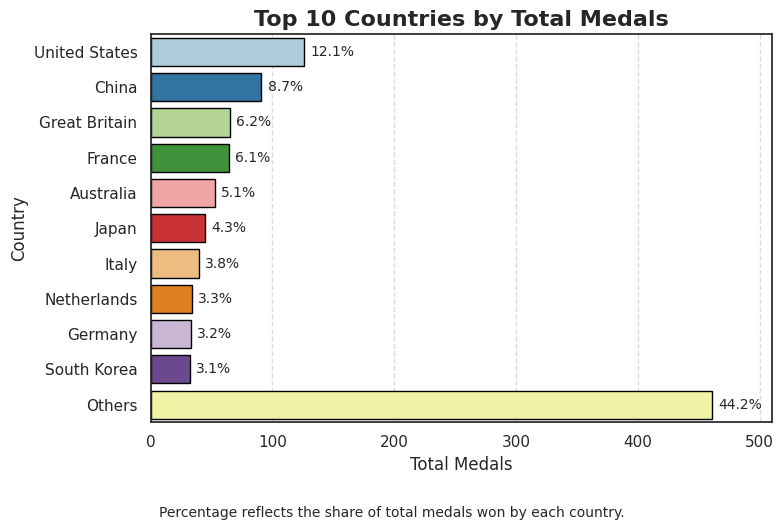

In [8]:
# ----------------------------------- #
# Top countries by overall medals won #
# ----------------------------------- #

TOP_N = 10

temp = medal_summary.head(TOP_N)

remaining_medals = medal_summary.iloc[TOP_N:].Total_Medals.sum()

others_df = pd.DataFrame({'NOC': ['Others'], 'Total_Medals': [remaining_medals]})
temp = pd.concat([temp, others_df], ignore_index=True)

total_medals = temp.Total_Medals.sum()
temp['Percentage'] = (temp.Total_Medals / total_medals) * 100

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(
    data=temp,
    y='NOC',
    x='Total_Medals',
    palette='Paired',
    edgecolor='black',
    ax=ax
)

ax.set_title(f'Top {TOP_N} Countries by Total Medals', fontsize=16, weight='bold')
ax.set_xlabel('Total Medals', fontsize=12)
ax.set_ylabel('Country', fontsize=12)
plt.yticks(rotation=0)
plt.xlim((0, 510))

ax.grid(axis='x', linestyle='--', alpha=0.7)

for index, row in temp.iterrows():
    ax.text(row.Total_Medals + 5, index, f'{row.Percentage:.1f}%', va='center', fontsize=10)
    
plt.figtext(0.5, -0.05, 'Percentage reflects the share of total medals won by each country.', 
            wrap=True, horizontalalignment='center', fontsize=10)    

plt.tight_layout()
plt.show()

Let's check how many countries were not able to win any medals. 

# 🪣 Medal Buckets. <a class="anchor"  id="chapter3"></a>

In [9]:
nr_countries_without_any_medals = medal_summary[medal_summary['Total_Medals']==0].shape[0]
print(f"There were {nr_countries_without_any_medals} countries who did not win any medals.")

There were 0 countries who did not win any medals.


Interestingly, there weren't any countries who did not win any medals. Meaning, __every country who attended the summer olympics 2024 in Paris was able to win at least one medal__. Let's now check the distribution of the buckets of medal wins.

In [10]:
bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-100']

medal_summary['Medal_Range'] = pd.cut(medal_summary['Total_Medals'], bins=bins, labels=labels, right=False)
medal_count_summary = medal_summary.groupby('Medal_Range').size().reset_index(name='Number_of_Countries')
medal_count_summary['Share_of_Countries'] = round(100 * medal_count_summary['Number_of_Countries'] / medal_count_summary['Number_of_Countries'].sum(), 3)
medal_count_summary['Cumulative_Share'] = medal_count_summary['Share_of_Countries'].cumsum()

medal_count_summary

,Medal_Range,Number_of_Countries,Share_of_Countries,Cumulative_Share
0,0-4,45,48.913,48.913
1,5-9,26,28.261,77.174
2,10-14,7,7.609,84.783
3,15-19,2,2.174,86.957
4,20-24,2,2.174,89.131
5,25-29,1,1.087,90.218
6,30-34,3,3.261,93.479
7,35-39,0,0.000,93.479
8,40-49,2,2.174,95.653
9,50-59,1,1.087,96.740


- More than 77% of all countries won less than 10 medals.
- This means, __only 1 out of 4 countries won 10 or more medals__
- Only 10% of all countries won at least 30 medals.

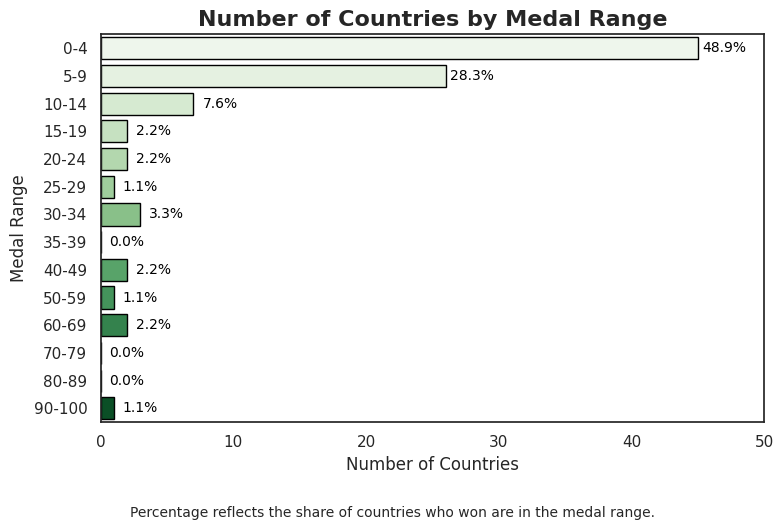

In [11]:
plt.figure(figsize=(8, 5))

ax = sns.barplot(medal_count_summary, y='Medal_Range', x='Number_of_Countries',
                 palette='Greens', edgecolor='black');
plt.title('Number of Countries by Medal Range', fontsize=16, weight='bold')
plt.xlabel('Number of Countries');
plt.ylabel('Medal Range');
plt.xlim((0, 50));
plt.yticks(rotation=0);

for index, row in medal_count_summary.iterrows():
    ax.text(row['Number_of_Countries'] + 2.0, index, f"{row['Share_of_Countries']:.1f}%", 
            fontsize=10, color='black', ha="center", va="center")

plt.figtext(0.5, -0.05, 'Percentage reflects the share of countries who won are in the medal range.', 
            wrap=True, horizontalalignment='center', fontsize=10)      
    
plt.tight_layout()    
plt.show();

The drop from below 15 won medals to 15 or above is massive. Only 15% of all countries won 15 or more medals.

# 🔬 Investigating Competitions. <a class="anchor"  id="chapter4"></a>

In this section we are going to investigate the won medals by discipline. 

In [12]:
olympics.head(3)

,Competitions,Rank,NOC,Gold,Silver,Bronze,Total,Country_Flag
0,Archery,1,South Korea,5,1,1,7,🇰🇷
1,Archery,2,France,0,1,1,2,🇫🇷
2,Archery,3,United States,0,1,1,2,🇺🇸


In [13]:
olympics.columns

Index(['Competitions', 'Rank', 'NOC', 'Gold', 'Silver', 'Bronze', 'Total',
       'Country_Flag'],
      dtype='object')

## 📊 Medal Distribution by Competition. <a class="anchor"  id="section_4_1"></a>

In this section we are going to take a look at how the number of possible medals to win differs between competitions. 

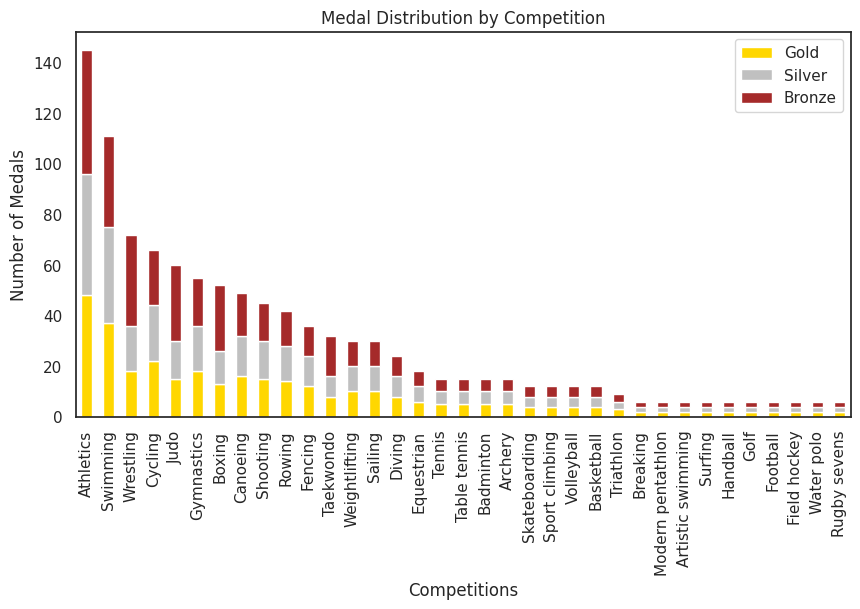

In [14]:
# --- Prepare ---
competition_medals = olympics.groupby('Competitions')[['Gold', 'Silver', 'Bronze']].sum()
competition_medals['Total'] = competition_medals.sum(axis=1)
competition_medals = competition_medals.sort_values(by='Total', ascending=False)
competition_medals = competition_medals.drop(columns='Total')

# --- Visualize---
competition_medals.plot(kind='bar', stacked=True, figsize=(10, 5), color=['gold', 'silver', 'brown'])
plt.title('Medal Distribution by Competition')
plt.ylabel('Number of Medals')
plt.xlabel('Competitions')
plt.xticks(rotation=90)
plt.show()

- With 140 overall medals, _Athletics_ is the competition with the highest number of medals.
- With more than 115 medals, _Swimming_ is the competition with the 2nd highest number of medals.
- Suprisingly to me, with more than 70, ___Wrestling_ has the 3rd highest number of medals__. 
    - Furthermore, _Wrestling_, _Boxing_ & _Taekwondo_ have the __highest share of 🥉 Bronze Medals__ compared to all other competitions. I think this is because everyone who lost the semi-final get's a 🥉 bronze medal in olympic fighting sports. 

## 🏆 Top Performing Countries by Competition.  <a class="anchor"  id="section_4_2"></a>

In [15]:
top_countries_per_competition = olympics.groupby(['Competitions', 'NOC'])['Total'].sum().reset_index()
top_countries_per_competition = top_countries_per_competition.sort_values(['Competitions', 'Total'], ascending=[True, False])
top_countries_per_competition.head(3)

,Competitions,NOC,Total
4,Archery,South Korea,7
1,Archery,France,2
6,Archery,United States,2


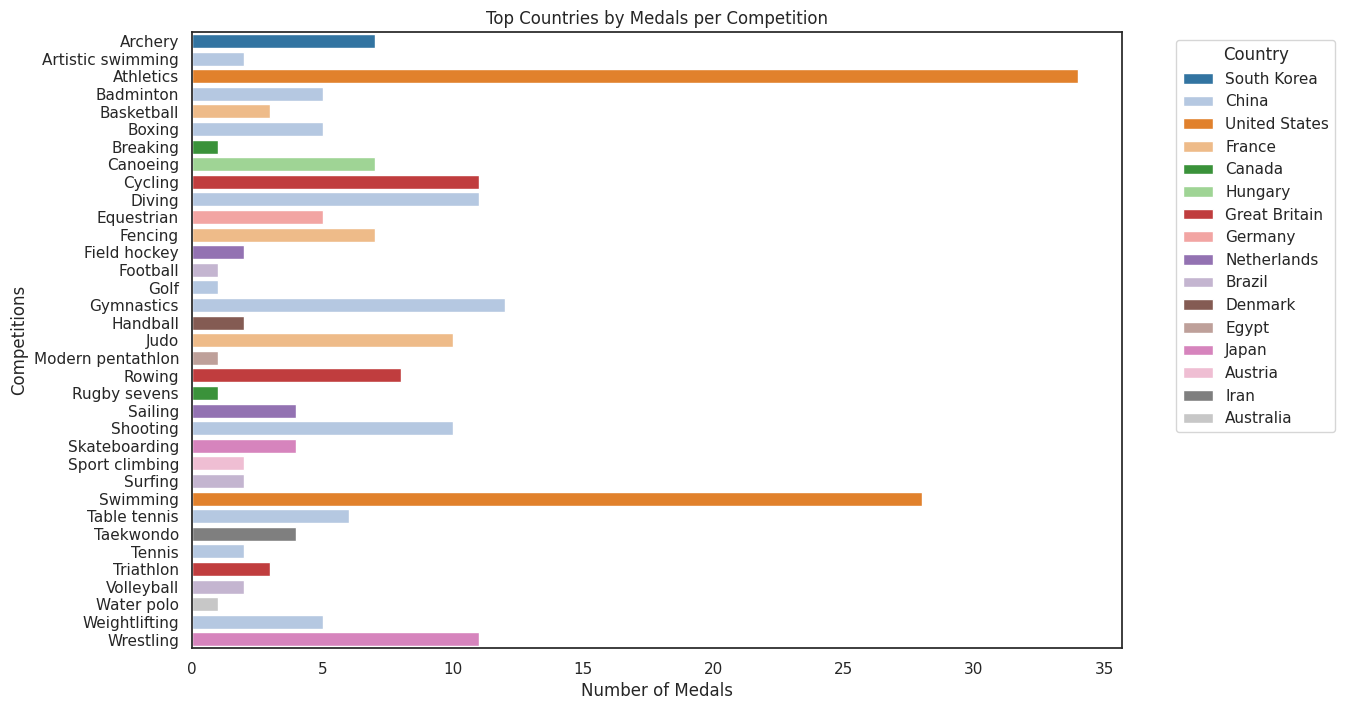

In [16]:
# --- Prepare ---
palette = sns.color_palette("tab20", n_colors=len(top_countries_per_competition['Competitions'].unique()))

top_countries_per_competition = olympics.groupby(['Competitions', 'NOC'])['Total'].sum().reset_index()
top_countries_per_competition = top_countries_per_competition.sort_values(['Competitions', 'Total'], ascending=[True, False])
top_countries_per_competition = top_countries_per_competition.drop_duplicates(subset=['Competitions'], keep='first')

# --- Visualize ---
plt.figure(figsize=(12, 8))
sns.barplot(y='Competitions', x='Total', hue='NOC', data=top_countries_per_competition, dodge=False, palette=palette)
plt.title('Top Countries by Medals per Competition')
plt.xlabel('Number of Medals')
plt.ylabel('Competitions')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Let's also simply print this. 

In [17]:
print(f"Countries with the most won medals per competition.")
print("===================================================\n")
for index, row in top_countries_per_competition.sort_values(['NOC']).iterrows():
    comp = row['Competitions']
    noc = row['NOC']
    flag = olympics[olympics['NOC']==noc]['Country_Flag'].unique()[0]
    
    print(f"{comp:20}  {flag}{noc:15} won {row['Total']:3.0f} medals.")

Countries with the most won medals per competition.

Water polo            🇦🇺Australia       won   1 medals.
Sport climbing        🇦🇹Austria         won   2 medals.
Football              🇧🇷Brazil          won   1 medals.
Surfing               🇧🇷Brazil          won   2 medals.
Volleyball            🇧🇷Brazil          won   2 medals.
Breaking              🇨🇦Canada          won   1 medals.
Rugby sevens          🇨🇦Canada          won   1 medals.
Tennis                🇨🇳China           won   2 medals.
Shooting              🇨🇳China           won  10 medals.
Weightlifting         🇨🇳China           won   5 medals.
Gymnastics            🇨🇳China           won  12 medals.
Golf                  🇨🇳China           won   1 medals.
Table tennis          🇨🇳China           won   6 medals.
Diving                🇨🇳China           won  11 medals.
Boxing                🇨🇳China           won   5 medals.
Badminton             🇨🇳China           won   5 medals.
Artistic swimming     🇨🇳China           won   2 med

- Interestingly, the USA 🇺🇸, who we saw is the country with the most overall won medals, only won the most medals in two competitions. But as we saw in Section "_Medal Distribution by Competition_" these competitions are also the competitions in which athletes can win the most medals, namely _Athletics_ and _Swimming_. 
- The country with the most occurences in the list of countries with the most won medals by competition is China 🇨🇳.

In [18]:
100*top_countries_per_competition['NOC'].value_counts(normalize=True)

NOC
China            28.571429
France            8.571429
Great Britain     8.571429
Brazil            8.571429
United States     5.714286
Canada            5.714286
Netherlands       5.714286
Japan             5.714286
South Korea       2.857143
Hungary           2.857143
Germany           2.857143
Denmark           2.857143
Egypt             2.857143
Austria           2.857143
Iran              2.857143
Australia         2.857143
Name: proportion, dtype: float64

- In more than 28% of all competitions China 🇨🇳 was the country which won the most medals in that competition.
- The USA 🇺🇸 however, was in less than 6% of all competitions the country which won the most medals.

## 👥 Competitions with Most Participation.  <a class="anchor"  id="section_4_3"></a>

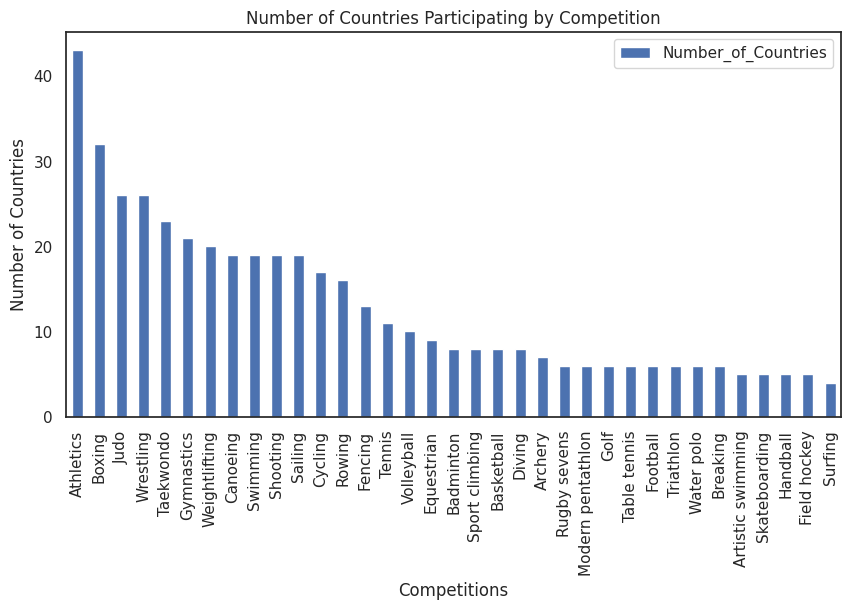

In [19]:
# --- Prepare ---
participation_count = olympics.groupby('Competitions')['NOC'].nunique().reset_index()
participation_count.columns = ['Competitions', 'Number_of_Countries']
participation_count = participation_count.sort_values(by='Number_of_Countries', ascending=False)
participation_count.plot(kind='bar', x='Competitions', y='Number_of_Countries', figsize=(10, 5))

# --- Visualize ---
plt.title('Number of Countries Participating by Competition')
plt.ylabel('Number of Countries')
plt.xlabel('Competitions')
plt.xticks(rotation=90)
plt.show()

---

💚 Thank you for reading 💚

If you have any questions or feedback, feel free to leave a comment 🤔

This notebook is __still in progress__.

Please __UPVOTE__ if you enjoyed this notebook 🙏